In [33]:
"""
Algorithm implementation
"""
import pickle
import numpy as np
import matplotlib.pyplot as plt
from essai import constellation
import scipy
from matplotlib import colors

from scipy.io.wavfile import read
from scipy.signal import spectrogram
from skimage.feature import peak_local_max
import random

# ----------------------------------------------------------------------------
# Create a fingerprint for an audio file based on a set of hashes
# ----------------------------------------------------------------------------


class Encoding:

    """
    Class implementing the procedure for creating a fingerprint 
    for the audio files

    The fingerprint is created through the following steps
    - compute the spectrogram of the audio signal
    - extract local maxima of the spectrogram
    - create hashes using these maxima

    """
    def __init__(self):

        """
        Class constructor

        To Do
        -----

        Initialize in the constructor all the parameters required for
        creating the signature of the audio files. These parameters include for
        instance:
        - the window selected for computing the spectrogram
        - the size of the temporal window 
        - the size of the overlap between subsequent windows
        - etc.

        All these parameters should be kept as attributes of the class.
        """

        # Insert code here
        
        self.window = 128
        self.noverlap = 32
      #   self.window = scipy.signal.get_window('triang', 128)
      #   self.window_size = len(self.window)

    def energie_min(self):      #on ajoute les points portant le plus d'énergie l'un après l'autre jusqu'à arriver à 90% de l'énergie totale.


          E_tot = np.sum(np.square(self.Sxx))
          print(f"l'énergie du signal est {E_tot}, le nombre de points est {np.prod(self.Sxx.shape)}")
          E = 0
          threshold_list = np.sort(self.Sxx,axis = None)[::-1]
          i = 0
          while E < 0.9*E_tot:            #on calcule l'énergie sur la durée entière, en ajoutant à chaque fois de nouvelles fréquences.
              threshold = threshold_list[i]
              mask = self.Sxx > threshold
              selected_sxx = self.Sxx[mask]
              E = np.sum(selected_sxx**2)
              i += 1
              print(i)
          print(f"la nouvelle énergie est {E}, soit {E/E_tot} % de la valeur initiale et le nombre de points est {len(self.Sxx[self.Sxx > threshold])}")
          indices_f, indices_t = np.indices(self.Sxx.shape)
          indices_f = indices_f[mask]
          indices_t = indices_t[mask]

          # self.Sxx[~mask] = 0
          # i=1
          # while i < len(self.Sxx):            #on supprime les lignes (fréquences) portant très peu d'énergie
          #   if np.sum(self.Sxx[-i]) == 0:
          #     self.Sxx = self.Sxx[:-1]
          #     self.f = self.f[:-1]
          #   else :
          #     i += 1
          mask = mask.sum(axis=1,dtype=bool)
          self.Sxx = self.Sxx[mask]
          self.f = self.f[mask]
          
          return(indices_f, indices_t)

    def process(self,fs,s, tmin = 0, duration = None, delta_t = 0.01):

        """

        To Do
        -----

        This function takes as input a sampled signal s and the sampling
        frequency fs and returns the fingerprint (the hashcodes) of the signal.
        The fingerprint is created through the following steps
        - spectrogram computation
        - local maxima extraction
        - hashes creation

        Implement all these operations in this function. Keep as attributes of
        the class the spectrogram, the range of frequencies, the anchors, the 
        list of hashes, etc.

        Each hash can conveniently be represented by a Python dictionary 
        containing the time associated to its anchor (key: "t") and a numpy 
        array with the difference in time between the anchor and the target, 
        the frequency of the anchor and the frequency of the target 
        (key: "hash")


        Parameters
        ----------

        fs: int
           sampling frequency [Hz]
        s: numpy array
           sampled signal
        """

        # Insert code here
        if duration != None : 
          s=s[tmin*fs : tmin*fs + duration*fs]
        else :
          s=s[tmin*fs :]
        self.spectr = spectrogram(s,fs,nperseg = self.window,noverlap = self.noverlap)
        self.f, self.t, self.Sxx = self.spectr

        self.energie_min()


        #self.spec = scipy.signal.spectrogram(s, fs, self.window, noverlap = 32)
        #self.f, self.t, self.Sxx = scipy.signal.spectrogram(s, fs, return_onesided=False)
        
        # self.constellation_indices = peak_local_max(self.Sxx, min_distance=1, exclude_border = False,indices = True)
        # print("indices :")
        # print(self.constellation_indices)
        # t = self.t[self.constellation_indices[:,1]]
        # f = self.f[self.constellation_indices[:,0]]
        # n = len(t)
        # delta_f = 500     #définition des seuils 

        # self.hashes = []
        # for a in range(n):
        #   for i in range(a,n):
        #     dt = t[i] - t[a]
        #     if abs(dt) < delta_t and abs(f[a] - f[i]) < delta_f:
        #       hash = {"t" : t[a], "hash":np.array([dt,f[a],f[i]])}
        #       self.hashes.append(hash)
              



    def display_spectrogram(self, display_anchors = True):
       #indices_f, indices_t = self.energie_min()
       plt.figure(figsize=(10,10))
       plt.pcolormesh(self.t,self.f,self.Sxx, norm = colors.LogNorm())
       if display_anchors :
          t = self.t[self.constellation_indices[:,1]]
          f = self.f[self.constellation_indices[:,0]]
          plt.scatter(t,f,color = 'red', marker = 'o')

    def compare_distance(self):         #teste quelle part de l'énergie et combien de maxima restent en augmentant la distance entre les maxima
            E_tot = np.sum(self.Sxx**2)
            dist_list = [1,5,10,50,100,500,1000]
            for distance in dist_list:
              mask_maxi = peak_local_max(self.Sxx, min_distance=distance, exclude_border = False, indices = False)
              constellation = self.Sxx[mask_maxi]
              E = np.sum(constellation**2)
              nb_max = np.sum(mask_maxi)
              print(f"distance : {distance}, énergie :{E/E_tot}%, nombre de maxima :{nb_max}")

        #Construisons la constellation du morceau:
    delta_t = 0.01

        
        # def constellation(delta_t,coord_maxima):
        #    hash = {}
        #    x = coord_maxima[:,0]
        #    y = coord_maxima[:,1]
        #    for i in range(len(x)):
        #       for j in range(i,len(x)):
        #          if abs(x[i] - x[j]) < delta_t and abs(y[i] - y[j]):
        #             hash[f"{i}"] = {abs(i - j), y[i],y[j]}
        #             return hash
        # self.constellation = constellation(self.t, self.maxi)
        # return self.constellation

l'énergie du signal est 6667240472576.0, le nombre de points est 487435
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259


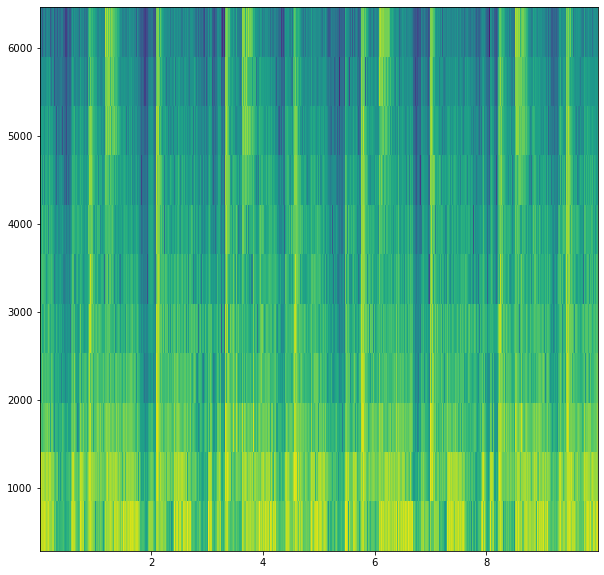

In [34]:
# ----------------------------------------------
# Run the script
# ----------------------------------------------
if __name__ == '__main__':

    encoder = Encoding()
    fs, s = read('samples\Cash Machine - Anno Domini Beats.wav')
    encoder.process(fs,s,tmin = 50, duration = 10, delta_t = 0.01)
    encoder.display_spectrogram(display_anchors=False)
    #encoder.compare_distance()
    # #encoder.display_spectrogram(display_anchors=True)
    #print(len(encoder.hashes))


In [ ]:
# ----------------------------------------------------------------------------
# Compares two set of hashes in order to determine if two audio files match
# ----------------------------------------------------------------------------

class Matching:

    """
    Compare the hashes from two audio files to determine if these
    files match

    Attributes
    ----------

    hashes1: list of dictionaries
       hashes extracted as fingerprints for the first audiofile. Each hash 
       is represented by a dictionary containing the time associated to
       its anchor (key: "t") and a numpy array with the difference in time
       between the anchor and the target, the frequency of the anchor and
       the frequency of the target (key: "hash")

    hashes2: list of dictionaries
       hashes extracted as fingerprint for the second audiofile. Each hash 
       is represented by a dictionary containing the time associated to
       its anchor (key: "t") and a numpy array with the difference in time
       between the anchor and the target, the frequency of the anchor and
       the frequency of the target (key: "hash")

    matching: numpy array
       absolute times of the hashes that match together

    offset: numpy array
       time offsets between the matches
    """

    def __init__(self, hashes1, hashes2):

        """
        Class constructor

        Compare the hashes from two audio files to determine if these
        files match

        To Do
        -----

        Implement a code establishing correspondences between the hashes of
        both files. Once the correspondences computed, construct the 
        histogram of the offsets between hashes. Finally, search for a criterion
        based on the histogram that allows to determine if both audio files 
        match

        Parameters
        ----------

        hashes1: list of dictionaries
           hashes extracted as fingerprint for the first audiofile. Each hash 
           is represented by a dictionary containing the time associated to
           its anchor (key: "t") and a numpy array with the difference in time
           between the anchor and the target, the frequency of the anchor and
           the frequency of the target

        hashes2: list of dictionaries
           hashes extracted as fingerprint for the second audiofile. Each hash 
           is represented by a dictionary containing the time associated to
           its anchor (key: "t") and a numpy array with the difference in time
           between the anchor and the target, the frequency of the anchor and
           the frequency of the target
        """


        self.hashes1 = hashes1
        self.hashes2 = hashes2

        # Insert code here
        



             
    def display_scatterplot(self):
       """
        Display through a scatterplot the times associated to the hashes
        that match
        """
    
       
       keys1 = hashes1.key()
       keys2 = hashes2.key()
       time_cloud = [[],[]]
       for k1 in keys1:
           for k2 in keys2:
              if k1 == k2:
                 time_cloud[0].append(k1 - hashes1[f"k1"][0])
                 time_cloud[1].append(k2 - hashes2[f"k2"][0])
       plt.scatter(time_cloud[0],time_cloud[1])
       plt.show()


      

    def display_histogram(self):

        """
        Display the offset histogram
        """

        # Insert code here

In [76]:
"""
Create a database containing the hashcodes of the songs stored 
in the specified folder (.wav files only). 
The database is saved as a pickle file as a list of dictionaries.
Each dictionary has two keys 'song' and 'hashcodes', corresponding 
to the name of the song and to the hashcodes used as signature for 
the matching algorithm.
"""

from concurrent.futures import process
import numpy as np
import matplotlib.pyplot as plt

from scipy.io.wavfile import read
# from algorithm import *


# ----------------------------------------------
# Run the script
# ----------------------------------------------
if __name__ == '__main__':

    folder = './samples/'

    # 1: Load the audio files
    import os
    audiofiles = os.listdir(folder)
    audiofiles = [item for item in audiofiles if item[-4:] =='.wav']

    # 2: Set the parameters of the encoder
    # Insert your code here
    coder = Encoding()
    delta_t = 0.01
    table_fs_s = []
    for filename in audiofiles :
        fs, s = read(f"samples/{filename}")
        table_fs_s.append([fs, s])
    tmin = 50 # We select an extract starting at 50s ...
    duration = 10 # ... which lasts 10s
    
    # 3: Construct the database
    database = []
    # Insert your code here
    for fs, s in table_fs_s:
        database.append(coder.process(fs,s,tmin=tmin,duration=duration,delta_t=delta_t))

    # 4: Save the database
    with open('songs.pickle', 'wb') as handle:
        pickle.dump(database, handle, protocol=pickle.HIGHEST_PROTOCOL)



l'énergie du signal est 6667240472576.0, le nombre de points est 487435
la nouvelle énergie est 6000719953920.0, soit 0.9000305533409119 % de la valeur initiale et le nombre de points est 2487
indices :
[[   1 6629]
 [   1 7332]
 [   1 3648]
 ...
 [   1 2938]
 [   1 6673]
 [   1  984]]


c:\Users\antoi\Anaconda3\lib\site-packages\ipykernel_launcher.py:134: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


l'énergie du signal est 16539523072.0, le nombre de points est 487435
la nouvelle énergie est 14886582272.0, soit 0.9000611305236816 % de la valeur initiale et le nombre de points est 1113
indices :
[[   1 5920]
 [   1 5897]
 [   1 6730]
 ...
 [   1 4166]
 [   1 4052]
 [   1 5674]]
l'énergie du signal est 11328606437376.0, le nombre de points est 487435
la nouvelle énergie est 10196068859904.0, soit 0.9000285267829895 % de la valeur initiale et le nombre de points est 3536
indices :
[[   1 7342]
 [   1 5193]
 [   1 1700]
 ...
 [   2 3420]
 [   1 5847]
 [   2  952]]
l'énergie du signal est 2602670489600.0, le nombre de points est 487435
la nouvelle énergie est 2342511443968.0, soit 0.9000415205955505 % de la valeur initiale et le nombre de points est 3182
indices :
[[   1 2803]
 [   1 4681]
 [   1 6459]
 ...
 [   1 3593]
 [   3 6447]
 [   1  697]]
l'énergie du signal est 89096290304.0, le nombre de points est 487435
la nouvelle énergie est 80190144512.0, soit 0.9000390768051147 % de la 

In [29]:
A = np.array([[2,3],[2,10]])
mask = A > 2
print(mask)
mask2 = mask.sum(axis=0,dtype = bool)
print(mask2)
A [mask2]

[[False  True]
 [False  True]]
[False  True]


array([[ 2, 10]])